Residualization  of covariates from cognitive data \
Sex, Age, Handedness, Ethnicity

In [2]:
import os

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split

from neurostatx.statistics.harmonization import neuroCombat
from neurostatx.utils.preprocessing import merge_dataframes

In [3]:
# Setting up relevant paths
repository_path = "c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/GitHub/FuzzyClustering-PING"
abcd_data_path = "c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/data/"
ping_data_dir = "c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/datagathering/"
output_dir = "c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing/"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
# Load PING data
ping_data = pd.read_excel(f"{ping_data_dir}/ping_data_gathered.xlsx")

In [5]:
# Separate the covariates and the variates data
covars = ping_data[["Sex", "AgeMonths", "Ethnicity", "Handedness"]].copy()
vars = ping_data[["CardSort", "Flanker", "ImitationMemory",
                  "ListSorting", "OralReading", "PatternComparison",
                    "PictureVocab"]].copy()

covars = sm.add_constant(covars)


# Instantiating an empty dataframe to store the results
residuals = pd.DataFrame(index=ping_data.index)

# Running a linear regression model for eact variate
for var in vars.columns:
    model = OLS(vars[var], covars)
    results = model.fit()
    residuals[var] = results.resid


In [6]:
# Merging the residuals with the original data
ping_data_resid = pd.concat([ping_data.drop(columns=vars), residuals], axis=1)

# Saving the residualized data.
ping_data_resid.to_excel(f"{output_dir}/ping_data_residualized.xlsx", index=False, header=True)

In [7]:
# Verifier que la residiualisation a bien fonctionné

X = sm.add_constant(ping_data[["AgeMonths", "Sex", "Ethnicity", "Handedness"]])

for col in residuals.columns:
    model = sm.OLS(residuals[col], X).fit()
    print(f"\n{col}")
    print(model.summary().tables[1])
# Coef environ 0 = pas de relation entre les covariables et les variables d'intérêt, ce qui est le but de la residualisation.
# P values élevés (1) = pas de relation significative entre les covariables et les variables d'intérêt, ce qui est également le but de la residualisation.


CardSort
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.746e-15      0.124   3.84e-14      1.000      -0.242       0.242
AgeMonths   4.879e-19      0.000   1.52e-15      1.000      -0.001       0.001
Sex         1.353e-16      0.036   3.71e-15      1.000      -0.072       0.072
Ethnicity   3.851e-16      0.010   3.83e-14      1.000      -0.020       0.020
Handedness   4.51e-17      0.049   9.22e-16      1.000      -0.096       0.096

Flanker
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.182e-16      0.121   5.92e-15      1.000      -0.238       0.238
AgeMonths   1.409e-18      0.000   4.48e-15      1.000      -0.001       0.001
Sex         2.325e-16      0.036   6.49e-15      1.000      -0.070       0.070
Ethnicity   3.678e-16      0.010 

Running an exploratory and confirmatory factorial analysis on PING cognitive data \
The CLI script will be run from the command line

In [8]:
# Using the residualized data for the further analysis.
!ExploratoryFA --in-dataset "{output_dir}/ping_data_residualized.xlsx" --out-folder "{output_dir}/PING_EFA/" \
    --id-column subjectkey --desc-columns 12 --rotation oblimin --method minres --train_dataset_size 0.5 \
    -v -s -f --random_state 1234 --nb_factors 3

2026-02-17 21:43:59 Portable-Rosalie root[10292] INFO Validating input files and creating output folder c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing//PING_EFA/
2026-02-17 21:43:59 Portable-Rosalie root[10292] INFO Loading c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing//ping_data_residualized.xlsx
2026-02-17 21:44:00 Portable-Rosalie root[10292] INFO Splitting into train and test datasets. Using training dataset for EFA.
2026-02-17 21:44:00 Portable-Rosalie root[10292] INFO Bartlett's test of sphericity returned a p-value of 5.388164318917512e-196 and Keiser-Meyer-Olkin (KMO)test returned a value of 0.7808097223540312.


In [ ]:
# Pour que CFA trouve Graphviz (Sinon CFA fonctionne pas)
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"


In [ ]:
# ConfirmatoryFA with 3 models including the cognitives test with a loading over 0.3 
!ConfirmatoryFA --in-dataset "{output_dir}/PING_EFA/test_dataset.xlsx" --out-folder "{output_dir}/PING_CFA/" \
    --id-column subjectkey --desc-columns 12 \
    --model "VA =~ OralReading + PictureVocab" \
    --model "EFPS =~ PatternComparison + CardSort + Flanker" \
    --model "MEM =~ ImitationMemory + ListSorting" \
    -v -s -f

2026-02-19 15:21:39 Portable-Rosalie root[18584] INFO Validating input files and creating output folder c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing//PING_CFA/
2026-02-19 15:21:39 Portable-Rosalie root[18584] INFO Loading c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing//PING_EFA/test_dataset.xlsx
2026-02-19 15:21:40 Portable-Rosalie root[18584] INFO Performing Confirmatory Factorial Analysis (CFA) with the following model specification:
VA =~ OralReading + PictureVocab
EFPS =~ PatternComparison + CardSort + Flanker
MEM =~ ImitationMemory + ListSorting

2026-02-19 15:21:40 Portable-Rosalie root[18584] INFO Exporting results and statistics.


In [9]:
# Applying the CFA model on the raw data
!ApplyModel --in-dataset "{output_dir}/ping_data_residualized.xlsx" --out-folder "{output_dir}/PING_CFA_Apply/" \
    --id-column subjectkey --desc-columns 12 --model "{output_dir}/PING_CFA/cfa_model.pkl" -v -s -f

2026-02-19 15:48:25 Portable-Rosalie root[18700] INFO Validating input files and creating output folder c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing//PING_CFA_Apply/
2026-02-19 15:48:25 Portable-Rosalie root[18700] INFO Loading c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/result/preprocessing//ping_data_residualized.xlsx
2026-02-19 15:48:26 Portable-Rosalie root[18700] INFO Loading model
2026-02-19 15:48:27 Portable-Rosalie root[18700] INFO Applying model
2026-02-19 15:48:27 Portable-Rosalie root[18700] INFO Saving transformed dataset


Imputating stress, internalisation and externalisation variables within PING study \
Since PING does not have Stress, Int and EXt variables, we will fit a KNN (k-Nearest Neighbor) imputation model on the ABCD dataset, and use it to impute the 3 new variables in the PING study.

In [5]:
# Import PING CFA result 
ping_cfa = pd.read_excel(f"{output_dir}/PING_CFA_Apply/transformed_dataset.xlsx")
abcd_prepro = pd.read_excel(f"{abcd_data_path}/abcd_data_preprocessed.xlsx")

In [ ]:
# Imputing existing variables in the PING study
# Create a loop that test out various K values for the KNN imputer
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400]
results = []

for k in k_values:
    KNN_partial = KNNImputer(n_neighbors=k, weights="distance",
                             metric="nan_euclidean", keep_empty_features=True)
    KNN_partial.fit(abcd_prepro[["VA", "EFPS", "MEM"]])

    dict = {}
    for var in ["VA", "EFPS", "MEM"]:
        oneout = ping_cfa[["VA", "EFPS", "MEM"]].copy()
        oneout.loc[:, var] = oneout[var].apply(convert_to_nan)
        imputed = pd.DataFrame(KNN_partial.transform(oneout), columns=oneout.columns)
        dict[f"{var}_imputed"] = imputed[var].values
        
    dict["subjectkey"] = ping_cfa["subjectkey"]
    input_valid = merge_dataframes({"ping": ping_cfa, "imputed": pd.DataFrame(dict)}, index="subjectkey")

    r_va = stats.pearsonr(x=input_valid.VA, y=input_valid.VA_imputed)
    r_efps = stats.pearsonr(x=input_valid.EFPS, y=input_valid.EFPS_imputed)
    r_mem = stats.pearsonr(x=input_valid.MEM, y=input_valid.MEM_imputed)

    results.append([k, r_va[0], r_efps[0], r_mem[0]])

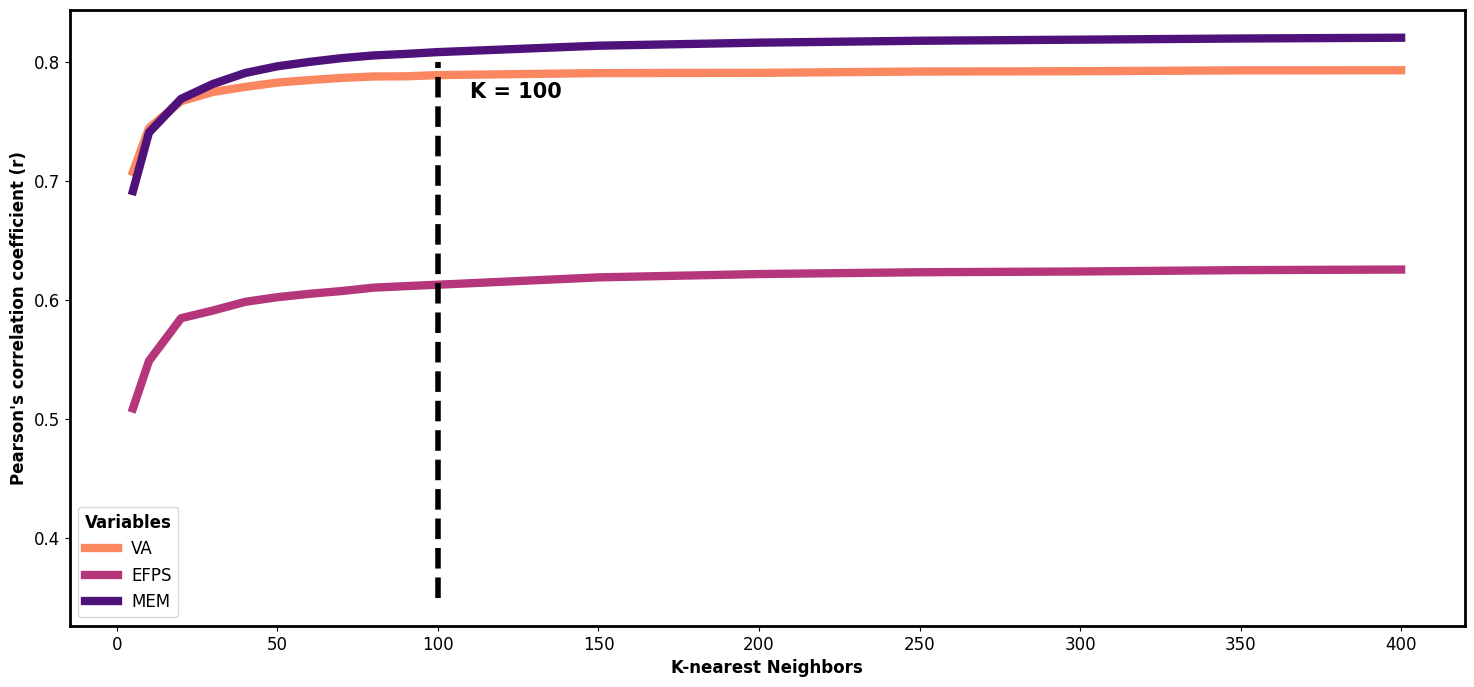

In [ ]:
# Plot those results in a line plot
results_df = pd.DataFrame(results, columns=["K", "VA", "EFPS", "MEM"])
results_df = results_df.melt(id_vars=["K"], value_vars=results_df.columns[1:])

with plt.rc_context(
    {"font.family": "Sans Serif",
     "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
     }
    ):
    fig, ax = plt.subplots(1, figsize=(18, 8))
    sns.lineplot(x="K", y="value", hue="variable", data=results_df, ax=ax,
                 palette="magma_r", linewidth=6)
    plt.plot([100, 100], [0.35, 0.80], "k--", lw=4)
    plt.text(110, 0.77, "K = 100", fontsize=15, weight="bold")
    ax.legend(title="Variables", loc="best",
              title_fontproperties={"weight": "bold", "size": 12})
    ax.spines[["left", "right", "top", "bottom"]].set(linewidth=2)
    ax.set_ylabel("Pearson's correlation coefficient (r)", fontdict={"fontweight": "bold"})
    ax.set_xlabel("K-nearest Neighbors", fontdict={"fontweight": "bold"})

    plt.show()

In [ ]:
# Impute the data using the optomal K value (150 est le début du plateau)
KNN_train = KNNImputer(n_neighbors=150, weights="distance",
                      metric="nan_euclidean", keep_empty_features=True)
KNN_train.fit(abcd_prepro[["VA", "EFPS", "MEM"]])

dict = {}
for var in ["VA", "EFPS", "MEM"]:
        oneout = ping_cfa[["VA", "EFPS", "MEM"]].copy()
        oneout.loc[:, var] = oneout[var].apply(convert_to_nan)
        imputed = pd.DataFrame(KNN_train.transform(oneout), columns=oneout.columns)
        dict[f"{var}_imputed"] = imputed[var].values

dict["subjectkey"] = ping_cfa["subjectkey"]
input_valid = merge_dataframes({"ping": ping_cfa, "imputed": pd.DataFrame(dict)}, index="subjectkey")

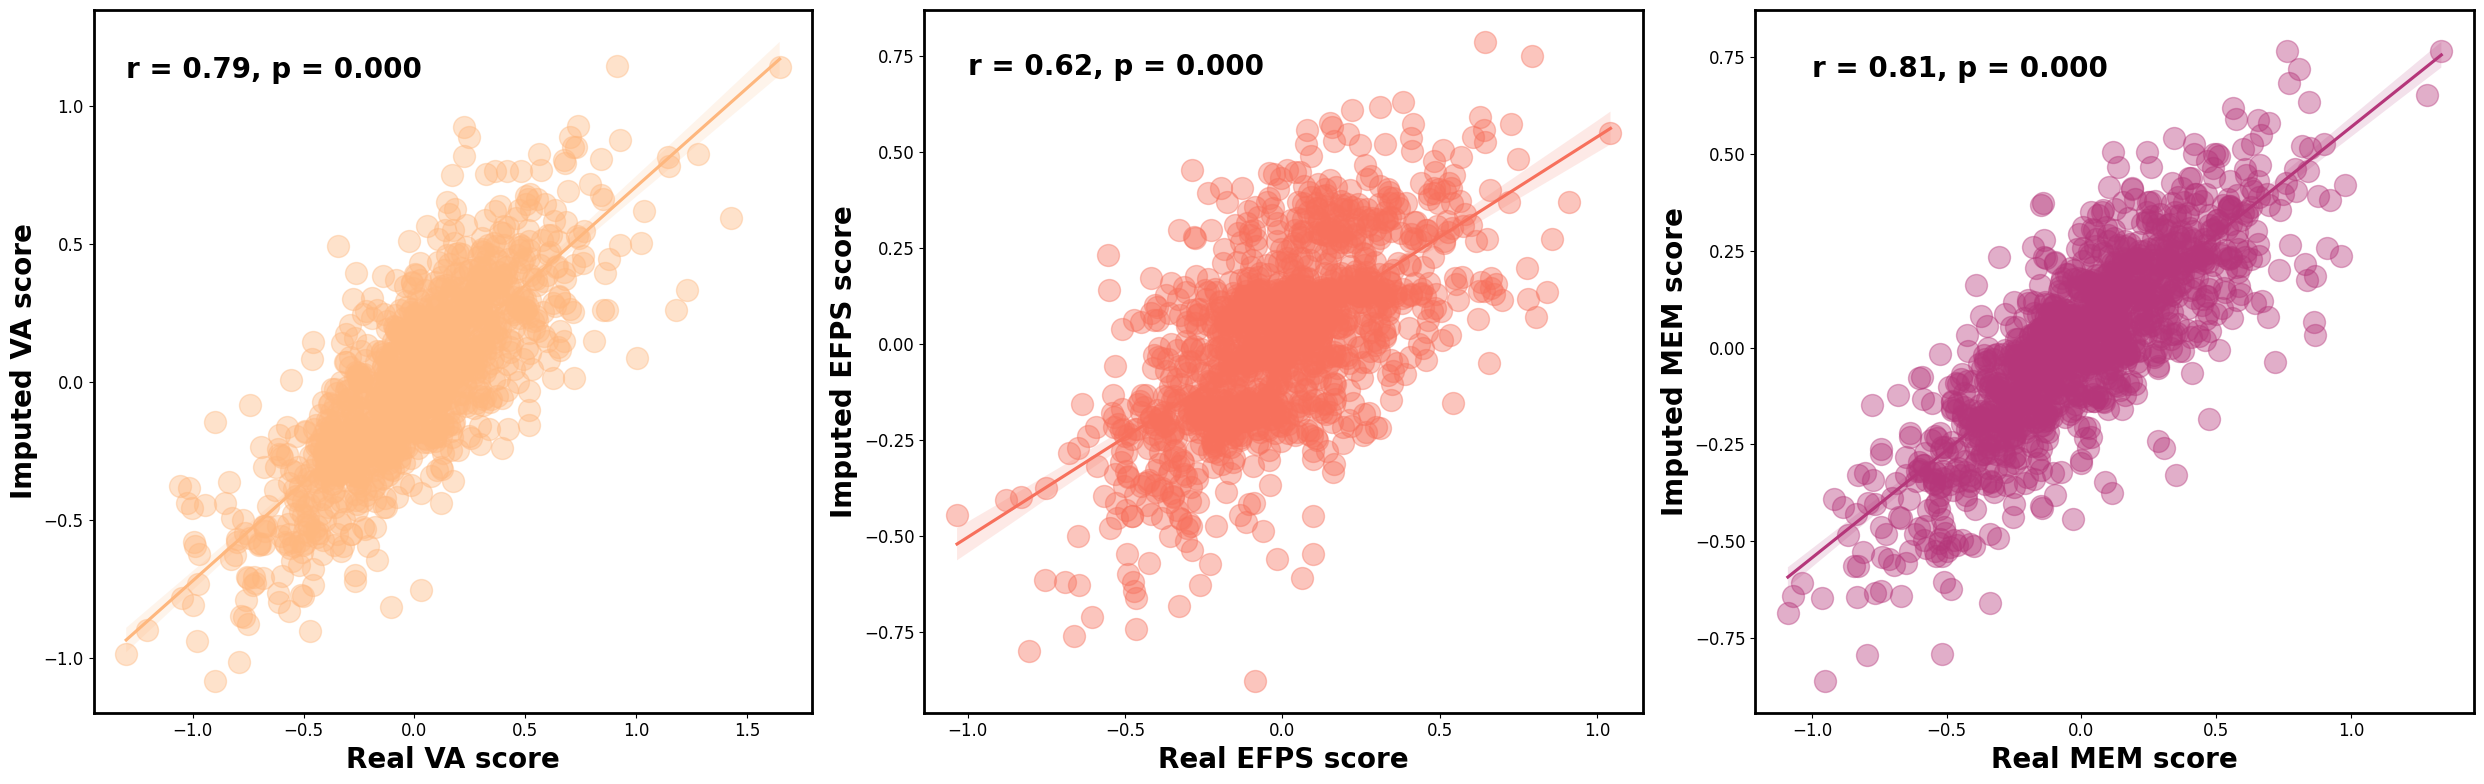

In [ ]:
# Validate using a leave-one-out approach
r_va = stats.pearsonr(x=input_valid.VA, y=input_valid.VA_imputed)
r_efps = stats.pearsonr(x=input_valid.EFPS, y=input_valid.EFPS_imputed)
r_mem = stats.pearsonr(x=input_valid.MEM, y=input_valid.MEM_imputed)

with plt.rc_context(
    {"font.family": "Sans Serif",
     "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
     }
    ):

    fig, ax = plt.subplots(1, 3, figsize=(25, 8))

    sns.regplot(ax=ax[0], x="VA", y="VA_imputed",
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.15),
                marker="o",
                robust=True,
                scatter_kws= {"s": 250, "alpha": 0.4, "color": plt.cm.magma_r(0.15)})

    ax[0].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[0].set_ylabel("Imputed VA score", fontdict={"fontweight": "bold", "size": 20})
    ax[0].set_xlabel("Real VA score", fontdict={"fontweight": "bold", "size": 20})

    ax[0].text(-1.3, 1.1, "r = {:.2f}, p = {:.3f}".format(r_va[0], r_va[1]), fontsize=20, weight="bold")

    sns.regplot(ax=ax[1], x="EFPS", y="EFPS_imputed",
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.3),
                marker="o",
                robust=True,
                scatter_kws= {"s": 250, "alpha": 0.4, "color": plt.cm.magma_r(0.3)})

    ax[1].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[1].set_ylabel("Imputed EFPS score", fontdict={"fontweight": "bold", "size": 20})
    ax[1].set_xlabel("Real EFPS score", fontdict={"fontweight": "bold", "size": 20})

    ax[1].text(-1, 0.7, "r = {:.2f}, p = {:.3f}".format(r_efps[0], r_efps[1]), fontsize=20, weight="bold")

    sns.regplot(ax=ax[2], x="MEM", y="MEM_imputed",
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.5),
                marker="o",
                robust=True,
                scatter_kws= {"s": 250, "alpha": 0.4, "color": plt.cm.magma_r(0.5)})

    ax[2].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[2].set_ylabel("Imputed MEM score", fontdict={"fontweight": "bold", "size": 20})
    ax[2].set_xlabel("Real MEM score", fontdict={"fontweight": "bold", "size": 20})

    ax[2].text(-1, 0.7, "r = {:.2f}, p = {:.3f}".format(r_mem[0], r_mem[1]), fontsize=20, weight="bold")

    plt.tight_layout()
    plt.show()

Maintenant on va entrainer la moitié de ABCD à prédire les variables comportementales (Stress, Internalisation et Externalisation)
à partir des variables cognitives VA, EFPS et MEM. Puis vérifier si c'est fiable dans la 2e moitié de ABCD

In [ ]:
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400]
results = []

# Variables cognitives (utilisé pour prédire)
cog_vars = ["VA", "EFPS", "MEM"]

# Variables comportementles (à prédire)
behav_vars = [ "Stress", "Internalization", "Externalization"]
all_vars = cog_vars + behav_vars

# Split 50/50 au hasard ABCD
abcd_train, abcd_test = train_test_split(
    abcd_prepro, test_size=0.5, random_state=123
)

for k in k_values:
    KNN_partial = KNNImputer(n_neighbors=k, weights="distance",
                             metric="nan_euclidean", keep_empty_features=True)
    KNN_partial.fit(abcd_train[all_vars])

    oneout = abcd_test[all_vars].copy()
    
# Masque les variables comportementales
    for var in behav_vars:
        oneout[var] = np.nan

    imputed = pd.DataFrame(KNN_partial.transform(oneout), columns=all_vars)

    dict = {}
    for var in behav_vars:
        dict[f"{var}_imputed"] = imputed[var].values

    dict["subjectkey"] = abcd_test["subjectkey"]
    input_valid = merge_dataframes({"true": abcd_test[["subjectkey"] + all_vars],
                                     "imputed": pd.DataFrame(dict)}, index="subjectkey")

# Calcule r pour chaque variable comportementale
    r_stress = stats.pearsonr(x=input_valid.Stress, y=input_valid.Stress_imputed)
    r_int = stats.pearsonr(x=input_valid.Internalization, y=input_valid.Internalization_imputed)
    r_ext = stats.pearsonr(x=input_valid.Externalization, y=input_valid.Externalization_imputed)

    results.append([k, r_stress[0], r_int[0], r_ext[0]])

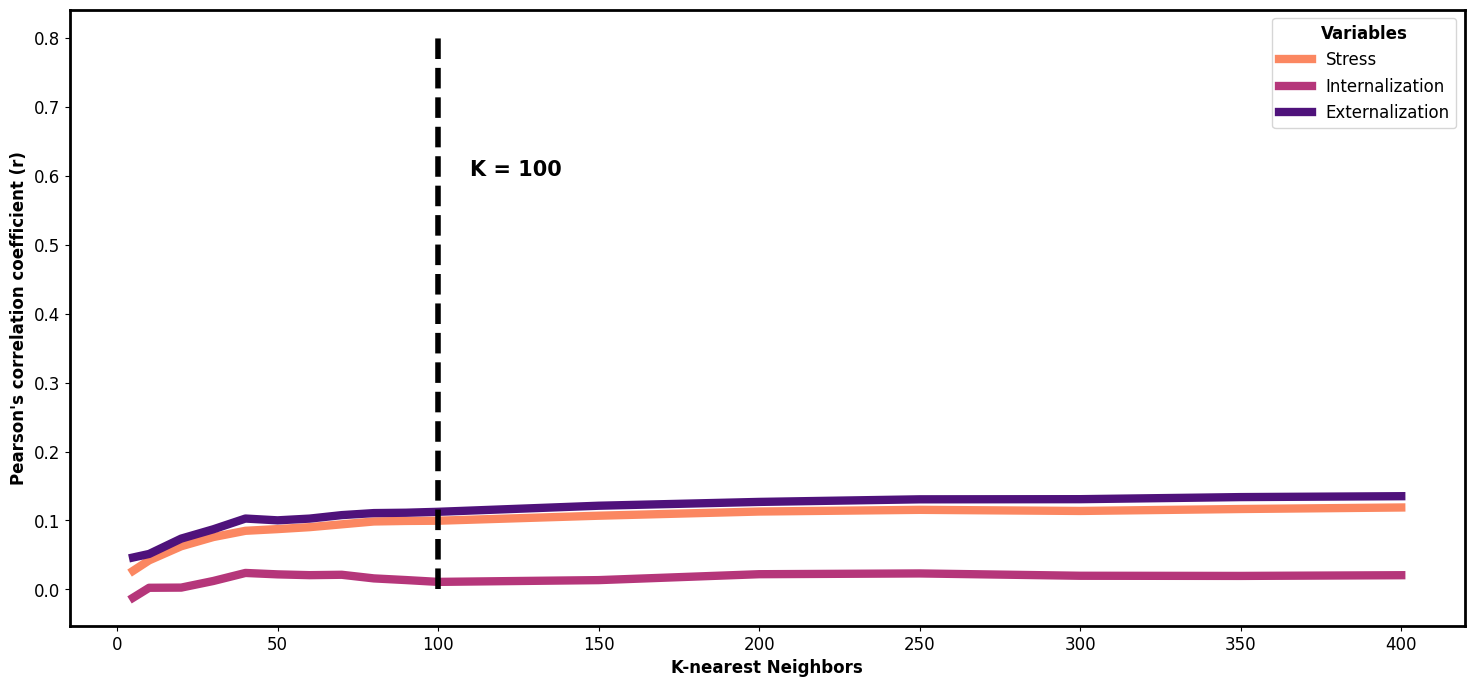

In [9]:
# Plot those results in a line plot
results_df = pd.DataFrame(results, columns=["K", "Stress", "Internalization", "Externalization"])
results_df = results_df.melt(id_vars=["K"], value_vars=results_df.columns[1:])

with plt.rc_context(
    {"font.family": "Sans Serif",
     "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
     }
    ):
    fig, ax = plt.subplots(1, figsize=(18, 8))
    sns.lineplot(x="K", y="value", hue="variable", data=results_df, ax=ax,
                 palette="magma_r", linewidth=6)
    plt.plot([100, 100], [0.0, 0.80], "k--", lw=4)
    plt.text(110, 0.6, "K = 100", fontsize=15, weight="bold")
    ax.legend(title="Variables", loc="best",
              title_fontproperties={"weight": "bold", "size": 12})
    ax.spines[["left", "right", "top", "bottom"]].set(linewidth=2)
    ax.set_ylabel("Pearson's correlation coefficient (r)", fontdict={"fontweight": "bold"})
    ax.set_xlabel("K-nearest Neighbors", fontdict={"fontweight": "bold"})

    plt.show()

In [ ]:
# Avec le nombre de neighbors optimal (je dirais 200, mais coefficient pas très bon..)
KNN_partial = KNNImputer(n_neighbors=200, weights="distance",
                             metric="nan_euclidean", keep_empty_features=True)
KNN_partial.fit(abcd_train[all_vars])

oneout = abcd_test[all_vars].copy()

# Masque les variables comportementales
for var in behav_vars:
        oneout[var] = np.nan

imputed = pd.DataFrame(KNN_partial.transform(oneout), columns=all_vars)

dict = {}
for var in behav_vars:
        dict[f"{var}_imputed"] = imputed[var].values
        
dict["subjectkey"] = abcd_test["subjectkey"]
input_valid = merge_dataframes({"true": abcd_test[["subjectkey"] + all_vars],
                                     "imputed": pd.DataFrame(dict)}, index="subjectkey")

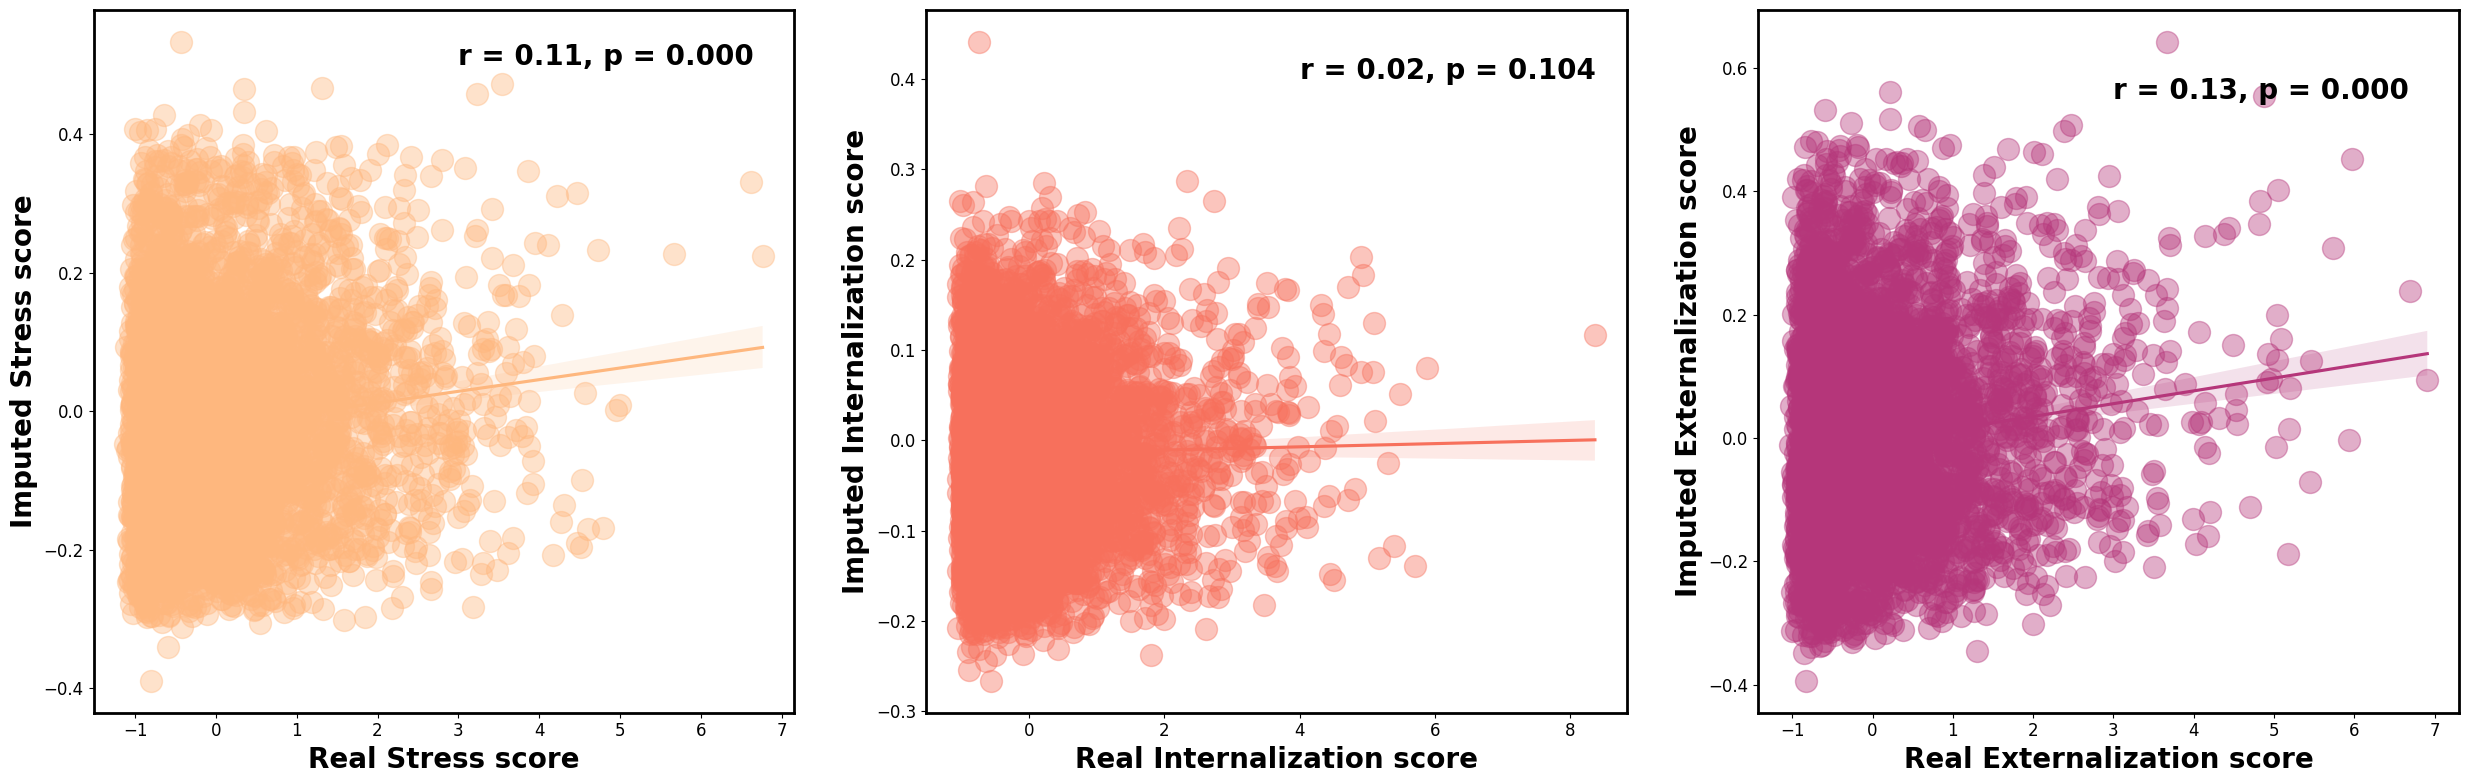

In [ ]:
# Validate using a leave-one-out approach in the second half of ABCD
r_stress = stats.pearsonr(x=input_valid.Stress, y=input_valid.Stress_imputed)
r_int = stats.pearsonr(x=input_valid.Internalization, y=input_valid.Internalization_imputed)
r_ext = stats.pearsonr(x=input_valid.Externalization, y=input_valid.Externalization_imputed)

with plt.rc_context(
    {"font.family": "Sans Serif",
     "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
     }
    ):

    fig, ax = plt.subplots(1, 3, figsize=(25, 8))

    sns.regplot(ax=ax[0], x="Stress", y="Stress_imputed",
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.15),
                marker="o",
                robust=True,
                scatter_kws= {"s": 250, "alpha": 0.4, "color": plt.cm.magma_r(0.15)})

    ax[0].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[0].set_ylabel("Imputed Stress score", fontdict={"fontweight": "bold", "size": 20})
    ax[0].set_xlabel("Real Stress score", fontdict={"fontweight": "bold", "size": 20})

    ax[0].text(3, 0.5, "r = {:.2f}, p = {:.3f}".format(r_stress[0], r_stress[1]), fontsize=20, weight="bold")

    sns.regplot(ax=ax[1], x="Internalization", y="Internalization_imputed",
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.3),
                marker="o",
                robust=True,
                scatter_kws= {"s": 250, "alpha": 0.4, "color": plt.cm.magma_r(0.3)})

    ax[1].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[1].set_ylabel("Imputed Internalization score", fontdict={"fontweight": "bold", "size": 20})
    ax[1].set_xlabel("Real Internalization score", fontdict={"fontweight": "bold", "size": 20})

    ax[1].text(4, 0.4, "r = {:.2f}, p = {:.3f}".format(r_int[0], r_int[1]), fontsize=20, weight="bold")

    sns.regplot(ax=ax[2], x="Externalization", y="Externalization_imputed",
                data=input_valid,
                ci=95, color=plt.cm.magma_r(0.5),
                marker="o",
                robust=True,
                scatter_kws= {"s": 250, "alpha": 0.4, "color": plt.cm.magma_r(0.5)})

    ax[2].spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax[2].set_ylabel("Imputed Externalization score", fontdict={"fontweight": "bold", "size": 20})
    ax[2].set_xlabel("Real Externalization score", fontdict={"fontweight": "bold", "size": 20})

    ax[2].text(3, 0.55, "r = {:.2f}, p = {:.3f}".format(r_ext[0], r_ext[1]), fontsize=20, weight="bold")

    plt.tight_layout()
    plt.show()

In [12]:
# Correlations bruts
abcd_prepro[["VA","EFPS","MEM","Stress","Internalization","Externalization"]].corr()

,VA,EFPS,MEM,Stress,Internalization,Externalization
VA,1.000000,0.660054,0.789202,-0.105683,-0.019432,-0.130543
EFPS,0.660054,1.000000,0.719879,-0.113699,-0.044190,-0.111916
MEM,0.789202,0.719879,1.000000,-0.127954,-0.046802,-0.138977
Stress,-0.105683,-0.113699,-0.127954,1.000000,0.833712,0.743979
Internalization,-0.019432,-0.044190,-0.046802,0.833712,1.000000,0.579137
Externalization,-0.130543,-0.111916,-0.138977,0.743979,0.579137,1.000000
